In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import sys as sys
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\salmansaeed.khan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\salmansaeed.khan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
df = pd.read_csv('D:/Personal-GIT/data/kaggle_toxic/train.csv')
print(df.head())
df_test.head()

                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\r\nWhy the edits made under my use...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\r\nMore\r\nI can't make any real suggestions...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  


NameError: name 'df_test' is not defined

### Tokenize Words - Check Distribution of Words

In [4]:
df['token_list'] = df['comment_text'].apply(lambda x: nltk.word_tokenize(x))
all_tokens = [item for sublist in df['token_list'] for item in sublist]
vocab_all = nltk.FreqDist(all_tokens)

In [5]:
vocab_words = {k: v for k, v in vocab_all.items() if k.isalpha()}
vocab_words = {k: v for k, v in sorted(vocab_words.items(), key=lambda item: item[1], reverse=True)}
vocab_series = pd.Series(dict(vocab_words))
#vocab_series

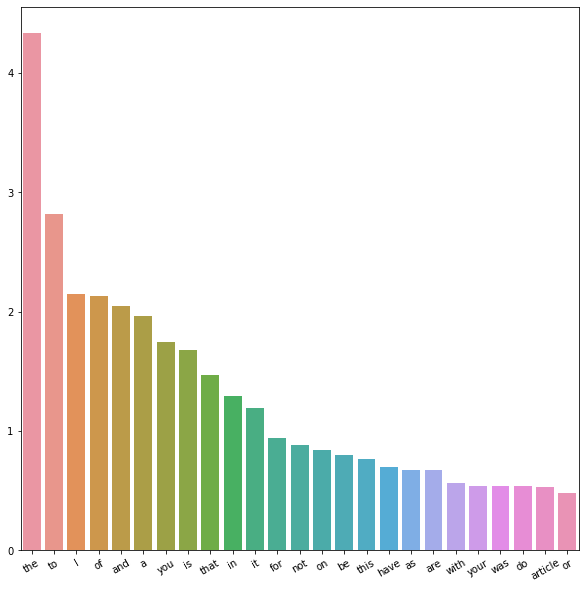

In [5]:
fig, ax = plt.subplots(figsize=(10,10))
vocab_series_top = vocab_series[:25]
all_plot = sns.barplot(x=vocab_series_top.index, y=100*vocab_series_top.values/sum(vocab_series.values), ax=ax)
plt.xticks(rotation=30);

## Remove Common Words

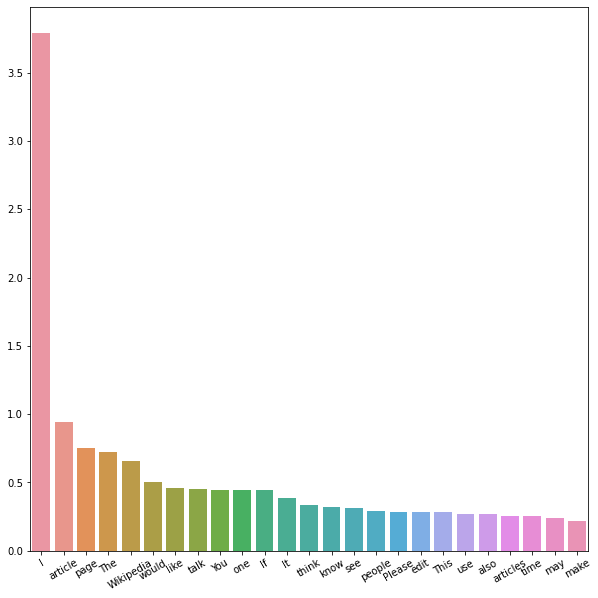

In [22]:
s=set(stopwords.words('english'))
vocab_words
vocab_words = {k: v for k, v in vocab_words.items() if k not in s}
vocab_words = {k: v for k, v in sorted(vocab_words.items(), key=lambda item: item[1], reverse=True)}
vocab_series = pd.Series(dict(vocab_words))
vocab_series
fig, ax = plt.subplots(figsize=(10,10))
vocab_series_top = vocab_series[:25]
all_plot = sns.barplot(x=vocab_series_top.index, y=100*vocab_series_top.values/sum(vocab_series.values), ax=ax)
plt.xticks(rotation=30);

## Transform Data in train and test set

In [2]:
sys.getrecursionlimit()

3000

In [3]:
#Load Train Test Data
df_train = pd.read_csv('D:/Personal-GIT/data/kaggle_toxic/train.csv')
df_test = pd.read_csv('D:/Personal-GIT/data/kaggle_toxic/test.csv')
y_test  = pd.read_csv('D:/Personal-GIT/data/kaggle_toxic/test_labels.csv')

In [4]:
#Tokenize Words
df_train['token_list'] = df_train['comment_text'].apply(lambda x: nltk.word_tokenize(x))
df_test['token_list'] = df_test['comment_text'].apply(lambda x: nltk.word_tokenize(x))

In [5]:
#Define vocab for the models and exclude stopping words.
min_word_length=3
max_word_length=10
frequency_word =2.5/100*round(df_train.shape[0])
s=set(stopwords.words('english'))

#Stemming
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()
df_train['token_list_processed'] = df_train['token_list'].apply(lambda x: set([lemmatizer.lemmatize(v) for v in x if ((len(v)>=min_word_length) & (len(v)<=max_word_length) & (v.isalpha()) & (v not in s))]))
df_test['token_list_processed'] = df_test['token_list'].apply(lambda x: set([lemmatizer.lemmatize(v) for v in x if ((len(v)>=min_word_length) & (len(v)<=max_word_length) & (v.isalpha()) & (v not in s))]))

#Add count of tokens
df_train['token_count'] = df_train['token_list'].apply(lambda x: len(x))
df_test['token_count'] = df_test['token_list'].apply(lambda x: len(x))

#Relevant Vocabulary from train set
all_tokens = [item for sublist in df_train['token_list_processed'] for item in sublist]
vocab_all = nltk.FreqDist(all_tokens)
vocab_words = {k: v for k, v in vocab_all.items() if v>=frequency_word} #keep words with alteast occurance of more than 2%
#vocab_words = {k: v for k, v in vocab_words.items() if v<=0.90*round(df.shape[0])} #keep words with alteast occurance of more than 0.5%
print(f'Vocab length {len(vocab_words)}')
df_train['token_list_processed_reduced_vocab'] = df_train['token_list_processed'].apply(lambda x: set([v for v in x if v in vocab_words]))
df_test['token_list_processed_reduced_vocab'] = df_test['token_list_processed'].apply(lambda x: set([v for v in x if v in vocab_words]))

Vocab length 151


In [6]:
#One Hot encoding for relevant vocabulary on test and train sets.
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer=lambda x: x)
vectorizer.fit(df_train['token_list_processed_reduced_vocab'])
features = vectorizer.get_feature_names()
len(features)

X_train = vectorizer.transform(df_train['token_list_processed_reduced_vocab'])
count_vect_df_train = pd.DataFrame(X_train.toarray(), columns=vectorizer.get_feature_names())
df_train = pd.concat([df_train, count_vect_df_train], axis=1)

#Test-data Encoding
X_test = vectorizer.transform(df_test['token_list_processed_reduced_vocab'])
count_vect_df_test = pd.DataFrame(X_test.toarray(), columns=vectorizer.get_feature_names())
df_test = pd.concat([df_test, count_vect_df_test], axis=1)

In [7]:
#Training & Test Data - subset relevant features
X_train = df_train.drop(columns=['id', 'comment_text','toxic','severe_toxic', 'obscene','threat','insult',
                                 'identity_hate','token_list','token_list_processed','token_list_processed_reduced_vocab'])
y_train = df_train[['toxic','severe_toxic', 'obscene','threat','insult','identity_hate']].apply(lambda x: 1 if sum(x) else 0, axis=1)
X_test = df_test.drop(columns=['id','comment_text','token_list','token_list_processed','token_list_processed_reduced_vocab'])

In [8]:
#Relevant Test Data - remove test sets where predictions missing.
y_test[['target']] = y_test[['toxic','severe_toxic', 'obscene','threat','insult','identity_hate']].apply(lambda x: 1 if sum(x) else 0, axis=1)
y_test[['Missing']] = y_test[['toxic','severe_toxic', 'obscene','threat','insult','identity_hate']].apply(lambda x: min(x), axis=1)
y_test_relevant = y_test[y_test['Missing']!=-1]['target']
X_test_relevant = X_test[y_test['Missing']!=-1]

#Dimenstions of test and train sets.
print(f'Train Features Shape = {X_train.shape}')
print(f'Test Features Shape = {X_test.shape}')
print(f'Relevant Test Features Shape = {X_test_relevant.shape}')

#Compare - Train Test Distributions.
print(f'Train set y mean = {np.mean(y_train)}')
print(f'Test set y mean = {np.mean(y_test_relevant)}')

Train Features Shape = (159571, 152)
Test Features Shape = (153164, 152)
Relevant Test Features Shape = (63978, 152)
Train set y mean = 0.10167887648758234
Test set y mean = 0.09758041826877989


## Finding the best ML Model for Classification:

In [9]:
## TRAIN MODEL
#TPOT Classifier
#!pip install tpot
from tpot import TPOTClassifier
tpot = TPOTClassifier(generations=4, population_size=40, verbosity=2, random_state=42)
tpot.fit(X_train, y_train)
tpot.export('tpot_products_pipeline.py')

C:\ProgramData\Anaconda3\lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")



Generation 1 - Current best internal CV score: 0.8997750226253816

Generation 2 - Current best internal CV score: 0.8998940894842418

Generation 3 - Current best internal CV score: 0.8998940894842418

Generation 4 - Current best internal CV score: 0.8998940894842418

Best pipeline: LogisticRegression(GaussianNB(input_matrix), C=15.0, dual=False, penalty=l2)


In [9]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from tpot.export_utils import set_param_recursive

# Average CV score on the training set was: 0.8998940894842418
exported_pipeline = make_pipeline(
    StackingEstimator(estimator=GaussianNB()),
    LogisticRegression(C=15.0, dual=False, penalty="l2",solver='lbfgs', max_iter=1000)
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', 42)

exported_pipeline.fit(X_train, y_train)
prediction = exported_pipeline.predict(X_test_relevant)

C:\ProgramData\Anaconda3\lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import recall_score as recall
from sklearn.metrics import precision_score as precision
from sklearn.metrics import f1_score
 
cmtp = confusion_matrix(y_test_relevant, prediction)
acc  = accuracy(y_test_relevant, prediction)
rec  = recall(y_test_relevant, prediction)
prec = precision(y_test_relevant, prediction)
f1   = f1_score(y_test_relevant, prediction)
print(f'Accuracy = {round(acc,2)}, Precision = {prec}, Recall = {rec}, F1-score = {f1}')
print('Confusion Matrix is:')
print(cmtp)

Accuracy = 0.9, Precision = 0.33068362480127184, Recall = 0.033317315393240426, F1-score = 0.06053550640279395
Confusion Matrix is:
[[57314   421]
 [ 6035   208]]


## Sklearn - Count Vectorizer
CountVectorizer implements both tokenization and occurrence counting in a single class.

In [55]:
#Load Train Test Data
df_train = pd.read_csv('D:/Personal-GIT/data/kaggle_toxic/train.csv')
df_test = pd.read_csv('D:/Personal-GIT/data/kaggle_toxic/test.csv')
y_test  = pd.read_csv('D:/Personal-GIT/data/kaggle_toxic/test_labels.csv')

## Test train features
X_train = df_train.drop(columns=['id', 'toxic','severe_toxic', 'obscene','threat','insult','identity_hate'])
X_test  = df_test.drop(columns=['id']) 
y_train = df_train[['toxic','severe_toxic', 'obscene','threat','insult','identity_hate']].apply(lambda x: 1 if sum(x) else 0, axis=1)
y_test[['target']] = y_test[['toxic','severe_toxic', 'obscene','threat','insult','identity_hate']].apply(lambda x: 1 if sum(x) else 0, axis=1)
y_test[['Missing']] = y_test[['toxic','severe_toxic', 'obscene','threat','insult','identity_hate']].apply(lambda x: min(x), axis=1)
y_test_relevant = y_test[y_test['Missing']!=-1]['target']
X_test_relevant = X_test[y_test['Missing']!=-1]

In [56]:
#Sklearn - CountVectorizer
import operator
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(stop_words='english').fit(X_train['comment_text'])

#Longest 10 words
[(token, len(token)) for token in vect.vocabulary_.keys()]
sorted([(token, len(token)) for token in vect.vocabulary_.keys()], key=operator.itemgetter(1), reverse=True)[0] 

#Length of vocabulary
print(f'Length of vocabulary = {len(vect.vocabulary_.keys())}')

# Transform test and train data
X_train_transformed = vect.fit_transform(X_train['comment_text'])
X_test_transformed = vect.transform(X_test_relevant['comment_text'])

#Dimenstions of test and train sets.
print(f'Train Features Shape = {X_train_transformed.shape}')
print(f'Relevant Test Features Shape = {X_test_transformed.shape}')

#Compare - Train Test Distributions.
print(f'Train set y mean = {np.mean(y_train)}')
print(f'Test set y mean = {np.mean(y_test_relevant)}')

Lenght of vocabulary = 189460
Train Features Shape = (159571, 189460)
Relevant Test Features Shape = (63978, 189460)
Train set y mean = 0.10167887648758234
Test set y mean = 0.09758041826877989


In [61]:
## TRAIN MODEL
#TPOT Sparse Classsifier 
from tpot import TPOTClassifier
tpot = TPOTClassifier(generations=4, population_size=40, verbosity=2, random_state=42,config_dict='TPOT sparse')
tpot.fit(X_train_transformed, y_train)
tpot.export('tpot_products_pipeline_countvectorizer.py')


Generation 1 - Current best internal CV score: 0.9552550249828846

Generation 2 - Current best internal CV score: 0.955605966964464

Generation 3 - Current best internal CV score: 0.9558754386237233

Generation 4 - Current best internal CV score: 0.9571977297478277

Best pipeline: LinearSVC(input_matrix, C=0.5, dual=False, loss=squared_hinge, penalty=l1, tol=0.1)


In [62]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

# Average CV score on the training set was: 0.9571977297478277
exported_pipeline = LinearSVC(C=0.5, dual=False, loss="squared_hinge", penalty="l1", tol=0.1)
# Fix random state in exported estimator
if hasattr(exported_pipeline, 'random_state'):
    setattr(exported_pipeline, 'random_state', 42)

exported_pipeline.fit(X_train_transformed, y_train)
prediction = exported_pipeline.predict(X_test_transformed)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import recall_score as recall
from sklearn.metrics import precision_score as precision
from sklearn.metrics import f1_score
 
cmtp = confusion_matrix(y_test_relevant, prediction)
acc  = accuracy(y_test_relevant, prediction)
rec  = recall(y_test_relevant, prediction)
prec = precision(y_test_relevant, prediction)
f1   = f1_score(y_test_relevant, prediction)

print('Result of best TPOT Model with Sklearn Count Vectorizer')
print(f'Accuracy = {round(acc,2)}, Precision = {prec}, Recall = {rec}, F1-score = {f1}')
print('Confusion Matrix is:')
print(cmtp)

Result of best TPOT Model with Sklearn Count Vectorizer
Accuracy = 0.91, Precision = 0.5417671563253672, Recall = 0.7916065993913183, F1-score = 0.6432801822323462
Confusion Matrix is:
[[53555  4180]
 [ 1301  4942]]


In [52]:
#Naive Bayes
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB(alpha=0.1)
clf.fit(X_train_transformed, y_train)    
prediction= clf.predict(X_test_transformed)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import recall_score as recall
from sklearn.metrics import precision_score as precision
from sklearn.metrics import f1_score
 
cmtp = confusion_matrix(y_test_relevant, prediction)
acc  = accuracy(y_test_relevant, prediction)
rec  = recall(y_test_relevant, prediction)
prec = precision(y_test_relevant, prediction)
f1   = f1_score(y_test_relevant, prediction)

print('Result of Navie Bayes Model with Sklearn Count Vectorizer')
print(f'Accuracy = {round(acc,2)}, Precision = {prec}, Recall = {rec}, F1-score = {f1}')
print('Confusion Matrix is:')
print(cmtp)

Accuracy = 0.91, Precision = 0.5317035052467068, Recall = 0.7629344866250201, F1-score = 0.6266692980724953
Confusion Matrix is:
[[53540  4195]
 [ 1480  4763]]


# Sklearn - Tfidf Vectorizer
Convert a collection of raw documents to a matrix of TF-IDF features.
Equivalent to CountVectorizer followed by TfidfTransformer.

In [2]:
#Load Train Test Data
df_train = pd.read_csv('D:/Personal-GIT/data/kaggle_toxic/train.csv')
df_test = pd.read_csv('D:/Personal-GIT/data/kaggle_toxic/test.csv')
y_test  = pd.read_csv('D:/Personal-GIT/data/kaggle_toxic/test_labels.csv')

## Test train features
X_train = df_train.drop(columns=['id', 'toxic','severe_toxic', 'obscene','threat','insult','identity_hate'])
X_test  = df_test.drop(columns=['id']) 
y_train = df_train[['toxic','severe_toxic', 'obscene','threat','insult','identity_hate']].apply(lambda x: 1 if sum(x) else 0, axis=1)
y_test[['target']] = y_test[['toxic','severe_toxic', 'obscene','threat','insult','identity_hate']].apply(lambda x: 1 if sum(x) else 0, axis=1)
y_test[['Missing']] = y_test[['toxic','severe_toxic', 'obscene','threat','insult','identity_hate']].apply(lambda x: min(x), axis=1)
y_test_relevant = y_test[y_test['Missing']!=-1]['target']
X_test_relevant = X_test[y_test['Missing']!=-1]

In [14]:
#Tf-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer().fit(X_train['comment_text'])

#top and bottom features based on tf-idf.
feature_names = vect.get_feature_names()
idfs = vect.idf_
names_idfs = list(zip(feature_names, idfs))

import operator
#smallest tf-idfs
smallest = sorted(names_idfs, key=operator.itemgetter(1))[:20]
smallest = pd.Series([features[1] for features in smallest], index=[features[0] for features in smallest])

largest = sorted(names_idfs, key=operator.itemgetter(1), reverse=True)[:20]
largest = sorted(largest, key=operator.itemgetter(0))
largest = pd.Series([features[1] for features in largest], index=[features[0] for features in largest])

(smallest, largest)

(the     1.399704
 to      1.523261
 and     1.683704
 of      1.735374
 you     1.745691
 is      1.786071
 it      1.843795
 that    1.875579
 in      1.942687
 for     2.058241
 this    2.074570
 not     2.123774
 on      2.172444
 be      2.187330
 have    2.307512
 as      2.352069
 are     2.355101
 if      2.427280
 with    2.437017
 but     2.512216
 dtype: float64,
 0000000                     12.287103
 00000000                    12.287103
 0000000027                  12.287103
 00000001                    12.287103
 00000003                    12.287103
 00000050                    12.287103
 000001                      12.287103
 000002                      12.287103
 000002000004000008000016    12.287103
 0000030422                  12.287103
 0000035                     12.287103
 000023405011                12.287103
 00004                       12.287103
 000045                      12.287103
 00007632                    12.287103
 000080                      12.287103

In [15]:
# Transform test and train data based on tf-idf
X_train_transformed = vect.fit_transform(X_train['comment_text'])
X_test_transformed = vect.transform(X_test_relevant['comment_text'])

#Dimenstions of test and train sets.
print(f'Train Features Shape = {X_train_transformed.shape}')
print(f'Relevant Test Features Shape = {X_test_transformed.shape}')

#Compare - Train Test Distributions.
print(f'Train set y mean = {np.mean(y_train)}')
print(f'Test set y mean = {np.mean(y_test_relevant)}')

Train Features Shape = (159571, 189775)
Relevant Test Features Shape = (63978, 189775)
Train set y mean = 0.10167887648758234
Test set y mean = 0.09758041826877989


In [16]:
## TRAIN MODEL
#TPOT Sparse Classsifier 
from tpot import TPOTClassifier
tpot = TPOTClassifier(generations=4, population_size=40, verbosity=2, random_state=42,config_dict='TPOT sparse')
tpot.fit(X_train_transformed, y_train)
tpot.export('tpot_tfidfvectorizer.py')

C:\ProgramData\Anaconda3\lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")



Generation 1 - Current best internal CV score: 0.9619855722036774

Generation 2 - Current best internal CV score: 0.9620294400986452

Generation 3 - Current best internal CV score: 0.9620294400986452

Generation 4 - Current best internal CV score: 0.9620294400986452

Best pipeline: LinearSVC(CombineDFs(input_matrix, input_matrix), C=0.5, dual=False, loss=squared_hinge, penalty=l1, tol=0.01)


In [17]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from sklearn.svm import LinearSVC
from tpot.builtins import StackingEstimator
from tpot.export_utils import set_param_recursive
from sklearn.preprocessing import FunctionTransformer
from copy import copy

# Average CV score on the training set was: 0.9620294400986452
exported_pipeline = make_pipeline(
    make_union(
        FunctionTransformer(copy),
        FunctionTransformer(copy)
    ),
    LinearSVC(C=0.5, dual=False, loss="squared_hinge", penalty="l1", tol=0.01)
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', 42)

exported_pipeline.fit(X_train_transformed, y_train)
prediction = exported_pipeline.predict(X_test_transformed)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import recall_score as recall
from sklearn.metrics import precision_score as precision
from sklearn.metrics import f1_score
 
cmtp = confusion_matrix(y_test_relevant, prediction)
acc  = accuracy(y_test_relevant, prediction)
rec  = recall(y_test_relevant, prediction)
prec = precision(y_test_relevant, prediction)
f1   = f1_score(y_test_relevant, prediction)


print('Result of best TPOT Model with Sklearn Tf-IDF')
print(f'Accuracy = {round(acc,2)}, Precision = {prec}, Recall = {rec}, F1-score = {f1}')
print('Confusion Matrix is:')

print(cmtp)

Result of best TPOT Model with Sklearn Count Vectorizer
Accuracy = 0.92, Precision = 0.5775466845577547, Recall = 0.8273266057984943, F1-score = 0.6802317924404057
Confusion Matrix is:
[[53957  3778]
 [ 1078  5165]]


## Bi-grams and Tri-grams


In [2]:
#Load Train Test Data
df_train = pd.read_csv('D:/Personal-GIT/data/kaggle_toxic/train.csv')
df_test = pd.read_csv('D:/Personal-GIT/data/kaggle_toxic/test.csv')
y_test  = pd.read_csv('D:/Personal-GIT/data/kaggle_toxic/test_labels.csv')

## Test train features
X_train = df_train.drop(columns=['id', 'toxic','severe_toxic', 'obscene','threat','insult','identity_hate'])
X_test  = df_test.drop(columns=['id']) 
y_train = df_train[['toxic','severe_toxic', 'obscene','threat','insult','identity_hate']].apply(lambda x: 1 if sum(x) else 0, axis=1)
y_test[['target']] = y_test[['toxic','severe_toxic', 'obscene','threat','insult','identity_hate']].apply(lambda x: 1 if sum(x) else 0, axis=1)
y_test[['Missing']] = y_test[['toxic','severe_toxic', 'obscene','threat','insult','identity_hate']].apply(lambda x: min(x), axis=1)
y_test_relevant = y_test[y_test['Missing']!=-1]['target']
X_test_relevant = X_test[y_test['Missing']!=-1]

In [3]:
#Sklearn - 
# CountVectorizer with uni, bi and tri grams & 
#limit max features to 2000 top max_features ordered by term frequency across the corpus.

import operator
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(stop_words='english',ngram_range = (1,3),max_features=1000).fit(X_train['comment_text'])

features = (vect.get_feature_names())
len(features)

5000

In [4]:
#Tf-IDF with uni/bi and tri-grams
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(ngram_range = (1,3)).fit(X_train['comment_text'])

#top and bottom features based on tf-idf.
feature_names = vect.get_feature_names()
idfs = vect.idf_
names_idfs = list(zip(feature_names, idfs))

import operator
#smallest tf-idfs
smallest = sorted(names_idfs, key=operator.itemgetter(1))[:20]
smallest = pd.Series([features[1] for features in smallest], index=[features[0] for features in smallest])

largest = sorted(names_idfs, key=operator.itemgetter(1), reverse=True)[:20]
largest = sorted(largest, key=operator.itemgetter(0))
largest = pd.Series([features[1] for features in largest], index=[features[0] for features in largest])

(smallest, largest)

(the     1.399704
 to      1.523261
 and     1.683704
 of      1.735374
 you     1.745691
 is      1.786071
 it      1.843795
 that    1.875579
 in      1.942687
 for     2.058241
 this    2.074570
 not     2.123774
 on      2.172444
 be      2.187330
 have    2.307512
 as      2.352069
 are     2.355101
 if      2.427280
 with    2.437017
 but     2.512216
 dtype: float64,
 00 00 00           12.287103
 00 00 14           12.287103
 00 00 18           12.287103
 00 00 19           12.287103
 00 00 20           12.287103
 00 00 30           12.287103
 00 00 on           12.287103
 00 00 sky          12.287103
 00 00 the          12.287103
 00 00 utc          12.287103
 00 000             12.287103
 00 000 times       12.287103
 00 00pm            12.287103
 00 00pm at         12.287103
 00 00utc           12.287103
 00 00utc please    12.287103
 00 01 02           12.287103
 00 01 10           12.287103
 00 01 14           12.287103
 00 01 2004         12.287103
 dtype: float64)

In [5]:
# Transform test and train data based on tf-idf
X_train_transformed = vect.fit_transform(X_train['comment_text'])
X_test_transformed = vect.transform(X_test_relevant['comment_text'])

#Dimenstions of test and train sets.
print(f'Train Features Shape = {X_train_transformed.shape}')
print(f'Relevant Test Features Shape = {X_test_transformed.shape}')

#Compare - Train Test Distributions.
print(f'Train set y mean = {np.mean(y_train)}')
print(f'Test set y mean = {np.mean(y_test_relevant)}')

Train Features Shape = (159571, 8144648)
Relevant Test Features Shape = (63978, 8144648)
Train set y mean = 0.10167887648758234
Test set y mean = 0.09758041826877989


In [ ]:
## TRAIN MODEL
#TPOT Sparse Classsifier 
from tpot import TPOTClassifier
tpot = TPOTClassifier(generations=2, population_size=40, verbosity=2, random_state=42,config_dict='TPOT sparse')
tpot.fit(X_train_transformed, y_train)
tpot.export('tpot_tfidfvectorizer_bi_grams.py')

C:\ProgramData\Anaconda3\lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
